In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Semi-supervised learning with GAN

- train <G,D> with the GAN framework
- use unlabeled data
- then, transform the discriminator into a classifier (10 classes)
- here, we will use the Discriminator ! 

### About the data set

In [2]:
from keras.datasets.cifar10 import load_data

# train/val/test
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


x_train : (40000, 32, 32, 3) | uint8
y_train : (40000, 1) | uint8
x_val : (10000, 32, 32, 3) | uint8
y_val : (10000, 1) | uint8
x_test : (10000, 32, 32, 3) | uint8
y_test : (10000, 1) | int64


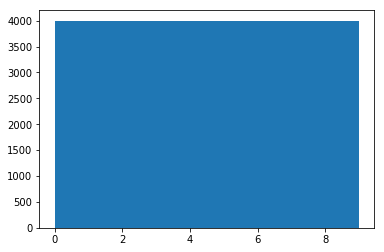

In [3]:
(x_train, y_train), (x_test, y_test) = load_data()

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, shuffle=True, stratify=y_train, test_size=0.2)

print("x_train : {} | {}".format(x_train.shape, x_train.dtype))
print("y_train : {} | {}".format(y_train.shape, y_train.dtype))
print("x_val : {} | {}".format(x_val.shape, x_val.dtype))
print("y_val : {} | {}".format(y_val.shape, y_val.dtype))
print("x_test : {} | {}".format(x_test.shape, x_test.dtype))
print("y_test : {} | {}".format(y_test.shape, y_test.dtype))
_ = plt.hist(y_train, bins=10)

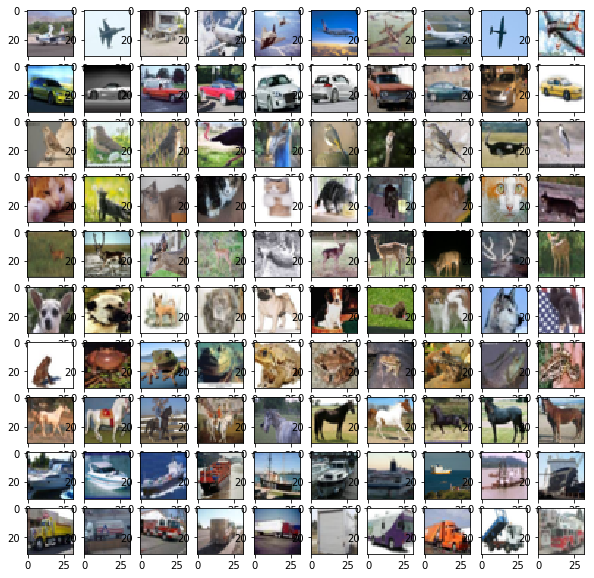

In [4]:
fig = plt.figure(figsize=(10, 10))
for id_class in range(10):
    indices = np.where(y_train==id_class)[0]
    for i in range(10):
        plt.subplot(10, 10, id_class*10 + i + 1)
        plt.imshow(x_train[indices[i]])
plt.show()

In [5]:
# minimal pre-processsing : scale to [-1, 1]
x_train = (x_train.astype(np.float32) / 127.5 ) - 1.
x_val = (x_val.astype(np.float32) / 127.5 ) - 1.
x_test = (x_test.astype(np.float32) / 127.5 ) - 1.

# DCGAN architecture : G and D are CNNs !

In [6]:
# tool box 
from keras.layers import Dense, Conv2D, MaxPooling2D, AveragePooling2D, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.layers import InputLayer, Input, Activation, UpSampling2D, Reshape, Flatten
from keras.models import Model, Sequential

from keras.optimizers import Adam

In [7]:
z_dim = 100
img_height = 32
img_width = 32

### Generator

In [8]:
input_G = Input(shape=(z_dim,))
x = Dense(128 * 4 * 4, activation="relu", input_shape=(z_dim,))(input_G)
x = Reshape((4, 4, 128))(x)
x = BatchNormalization(momentum=0.8)(x)
x = UpSampling2D()(x)
x = Conv2D(128, kernel_size=3, padding="same")(x)
x = Activation("relu")(x)
x = BatchNormalization(momentum=0.8)(x)
x = UpSampling2D()(x)
x = Conv2D(64, kernel_size=3, padding="same")(x)
x = Activation("relu")(x)
x = BatchNormalization(momentum=0.8)(x)
x = UpSampling2D()(x)
x = Conv2D(128, kernel_size=3, padding="same")(x)
x = Activation("relu")(x)
x = BatchNormalization(momentum=0.8)(x)
output_G = Conv2D(3, kernel_size=3, padding="same", activation='tanh')(x)

generator = Model(inputs=input_G, outputs=output_G)

generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              206848    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 128)         512       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
activation_1 (Activation)    (None, 8, 8, 128)         0         
__________

In [9]:
generator.compile(optimizer='adam', loss='binary_crossentropy')

### Discriminator

In [10]:
input_D = Input(shape=(img_height, img_width, 3))
x = Conv2D(32, kernel_size=3, strides=2, padding="same", input_shape=(img_height, img_width, 3))(input_D)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.25)(x)
x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.25)(x)
x = BatchNormalization(momentum=0.8)(x)
x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.25)(x)
x = BatchNormalization(momentum=0.8)(x)
x = Conv2D(256, kernel_size=3, strides=1, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
output_D = Dense(1, activation='sigmoid')(x)


discriminator = Model(inputs=input_D, outputs=output_D)
classifier = Model

discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 64)          0         
__________

In [11]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001, beta_1=0.5), metrics=['accuracy'])

### Combine 'G' and 'D', to train 'G'

In [12]:
discriminator.trainable = False

gan_input = Input(shape=(z_dim,))
gan_output = discriminator(generator(gan_input))

gan = Model(inputs=gan_input, outputs=gan_output)

In [13]:
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_1 (Model)              (None, 32, 32, 3)         507331    
_________________________________________________________________
model_2 (Model)              (None, 1)                 393281    
Total params: 900,612
Trainable params: 506,435
Non-trainable params: 394,177
_________________________________________________________________


In [14]:
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, beta_1=0.5), metrics=["accuracy"])

### Unsupervised 'joint' training

In [15]:
from keras.preprocessing.image import ImageDataGenerator

In [16]:
batch_size = 32
num_steps = 500

In [17]:
batch_gen = ImageDataGenerator().flow(batch_size=batch_size,
                                      x=x_train,
                                      shuffle=True)

(32, 32, 32, 3) float32


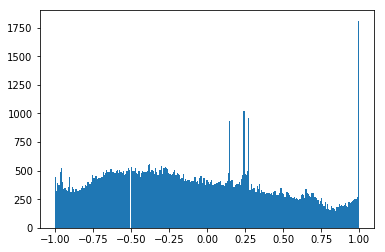

In [18]:
x = batch_gen.next()
print(x.shape, x.dtype)
_ = plt.hist(x.flatten(), bins=255)

In [19]:
i = 0

In [20]:
for step in range(num_steps):
    ###################################### TRAIN THE DISCRIMINATOR ###############################
    discriminator.trainable = True
    # generate fake images
    random_z_vectors = np.random.normal(size=(batch_size, z_dim))
    fake_images = generator.predict(random_z_vectors)
    labels = np.ones((batch_size, 1), dtype=np.float32)
    d_loss_1 = discriminator.train_on_batch(fake_images, labels)


    # get real images
    real_images = batch_gen.next()
    labels = np.zeros((real_images.shape[0], 1), dtype=np.float32)
    d_loss_2 = discriminator.train_on_batch(real_images, labels)

    # ############################################################################################

    ###################################### TRAIN THE GENERATOR ###################################
    discriminator.trainable = False
    random_z_vectors = np.random.normal(size=(batch_size, z_dim))
    misleading_labels = np.zeros((batch_size, 1))
    g_loss = gan.train_on_batch(random_z_vectors, misleading_labels)

    ###############################################################################################
    i +=1
    if i % 50 == 0:
        print("At {} iteration : ".format(i))
        print('\tdiscriminator loss: {}'.format((d_loss_1, d_loss_2)))
        print('\tgenerator loss:  {}'.format(g_loss))
    

At 50 iteration : 
	discriminator loss: ([0.53065991, 0.78125], [0.56354964, 0.71875])
	generator loss:  [1.0580194, 0.25]
At 100 iteration : 
	discriminator loss: ([0.54556781, 0.8125], [0.36177832, 0.875])
	generator loss:  [1.2006719, 0.09375]
At 150 iteration : 
	discriminator loss: ([0.55122375, 0.75], [0.54801655, 0.65625])
	generator loss:  [1.0821707, 0.34375]
At 200 iteration : 
	discriminator loss: ([0.34178165, 0.96875], [0.70484877, 0.5])
	generator loss:  [1.1051266, 0.21875]
At 250 iteration : 
	discriminator loss: ([0.46399507, 0.8125], [0.44642782, 0.8125])
	generator loss:  [1.4097676, 0.21875]
At 300 iteration : 
	discriminator loss: ([0.3759065, 0.78125], [0.2019867, 1.0])
	generator loss:  [1.6786518, 0.03125]
At 350 iteration : 
	discriminator loss: ([0.27656761, 0.9375], [0.25892556, 0.90625])
	generator loss:  [1.7782249, 0.0625]
At 400 iteration : 
	discriminator loss: ([0.24567382, 0.9375], [0.11219428, 1.0])
	generator loss:  [2.6368151, 0.0]
At 450 iteration 

In [21]:
def deprocess_images(x):
    x = (x + 1.)*127.5
    return np.clip(x, 0, 255).astype(np.uint8)

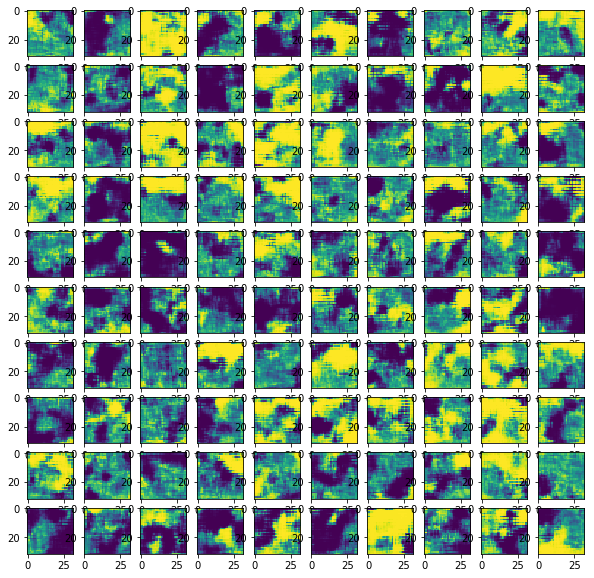

In [22]:
random_z_vectors = np.random.normal(size=(100, z_dim))
fake_images = generator.predict(random_z_vectors)


fig = plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(deprocess_images(fake_images[i,:,:,0]))
plt.show()

## Transform D as a classifier

- you can freeze some layers of the generator

In [23]:
discriminator.trainable = False

In [24]:
[(layer.name, layer.trainable, layer) for layer in discriminator.layers]

[('input_2', False, <keras.engine.topology.InputLayer at 0x7f0452dfca20>),
 ('conv2d_5', True, <keras.layers.convolutional.Conv2D at 0x7f0452dfc9e8>),
 ('leaky_re_lu_1',
  True,
  <keras.layers.advanced_activations.LeakyReLU at 0x7f0452dfcc50>),
 ('dropout_1', True, <keras.layers.core.Dropout at 0x7f0452dfcbe0>),
 ('conv2d_6', True, <keras.layers.convolutional.Conv2D at 0x7f0452dfce48>),
 ('leaky_re_lu_2',
  True,
  <keras.layers.advanced_activations.LeakyReLU at 0x7f0452d8c518>),
 ('dropout_2', True, <keras.layers.core.Dropout at 0x7f0452d8ad68>),
 ('batch_normalization_5',
  True,
  <keras.layers.normalization.BatchNormalization at 0x7f0452db6978>),
 ('conv2d_7', True, <keras.layers.convolutional.Conv2D at 0x7f0452d4c9b0>),
 ('leaky_re_lu_3',
  True,
  <keras.layers.advanced_activations.LeakyReLU at 0x7f0452d5c3c8>),
 ('dropout_3', True, <keras.layers.core.Dropout at 0x7f0452d6d898>),
 ('batch_normalization_6',
  True,
  <keras.layers.normalization.BatchNormalization at 0x7f0452cdd39

In [25]:
discriminator.input

AttributeError: Layer model_2 has multiple inbound nodes, hence the notion of "layer input" is ill-defined. Use `get_input_at(node_index)` instead.

In [26]:
discriminator.inbound_nodes

In [27]:
print(discriminator.get_input_at(0))
print(discriminator.get_input_at(1))

Tensor("input_2:0", shape=(?, 32, 32, 3), dtype=float32)
Tensor("model_1/conv2d_4/Tanh:0", shape=(?, 32, 32, 3), dtype=float32)


In [33]:
# get a layer from the discriminator
# then add you layers for the classifier

output_discriminator = discriminator.get_layer("leaky_re_lu_4").output

# here, jsute change the final layer ! (remove dropout)
x = Flatten()(output_discriminator)
output_classifier = Dense(10, activation='softmax')(x)

classifier = Model(inputs=discriminator.get_input_at(0), outputs=output_classifier)

In [34]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 64)          0         
__________

## Train the classifier with labeled data

In [35]:
from keras.utils import to_categorical

In [36]:
opt = Adam(lr=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

In [37]:
history = classifier.fit(x_train, to_categorical(y_train, num_classes=10),
                         epochs=10,
                         batch_size=32,
                         validation_data=(x_val, to_categorical(y_val, num_classes=10)),
                         shuffle=True,
                         verbose=1)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 110s - loss: 1.6066 - acc: 0.4426 - val_loss: 1.3767 - val_acc: 0.5131
Epoch 2/10
40000/40000 [==============================] - 108s - loss: 1.3480 - acc: 0.5272 - val_loss: 1.2716 - val_acc: 0.5474
Epoch 3/10
40000/40000 [==============================] - 112s - loss: 1.2295 - acc: 0.5681 - val_loss: 1.1366 - val_acc: 0.5950
Epoch 4/10
40000/40000 [==============================] - 108s - loss: 1.1261 - acc: 0.6050 - val_loss: 1.1171 - val_acc: 0.6092
Epoch 5/10
40000/40000 [==============================] - 109s - loss: 1.0451 - acc: 0.6330 - val_loss: 0.9603 - val_acc: 0.6633
Epoch 6/10
28288/40000 [====================>.........] - ETA: 30s - loss: 0.9836 - acc: 0.6547

KeyboardInterrupt: 